## Dataset loading

In [ ]:
from google.colab import drive
import zipfile
import os

In [ ]:
# Mount your Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to your zip file in Drive
zip_path = '/content/drive/MyDrive/SPOOFNET_DATASET_SPLIT.zip'

In [ ]:
# Destination folder to unzip
extract_path = '/content/SPOOFNET_DATASET_SPLIT'

In [ ]:
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

In [ ]:
import os

def count_images_in_directory(directory):
    count = 0
    # Walk through the directory and its subdirectories
    for root, dirs, files in os.walk(directory):
        for filename in files:
            # Check if the file is an image (you can add more image extensions if needed)
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                count += 1
    return count

train_dir = '/content/SPOOFNET_DATASET_SPLIT/SPOOFNET_DATASET_SPLIT/train'
val_dir = '/content/SPOOFNET_DATASET_SPLIT/SPOOFNET_DATASET_SPLIT/val'
test_dir = '/content/SPOOFNET_DATASET_SPLIT/SPOOFNET_DATASET_SPLIT/test'

train_count = count_images_in_directory(train_dir)
val_count = count_images_in_directory(val_dir)
test_count = count_images_in_directory(test_dir)

print(f"Number of images in train directory: {train_count}")
print(f"Number of images in validation directory: {val_count}")
print(f"Number of images in test directory: {test_count}")

Number of images in train directory: 14571
Number of images in validation directory: 3122
Number of images in test directory: 3126


## transfer learning using Custom SpoofNet

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# ========================================
# Hyperparameters
# ========================================

BATCH_SIZE = 16
NUM_EPOCHS = 5
LEARNING_RATE = 0.0001
WEIGHT_DECAY = 1e-4
IMG_SIZE = 224
PATIENCE = 7

In [ ]:
DATA_DIR = '/content/SPOOFNET_DATASET_SPLIT/SPOOFNET_DATASET_SPLIT'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VAL_DIR = os.path.join(DATA_DIR, 'val')
TEST_DIR = os.path.join(DATA_DIR, 'test')

In [ ]:
! ls /content/SPOOFNET_DATASET_SPLIT/SPOOFNET_DATASET_SPLIT

split_info.json  test  train  val


In [ ]:
# ========================================
# Optimized Data Augmentation
# ========================================
# Based on samples: Real images have natural skin texture, lighting, depth
# Spoof images show screen glare, pixelation, unnatural colors, flat appearance

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),

    # Geometric augmentations (moderate)
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),  # Reduced from 15 for face stability
    transforms.RandomAffine(
        degrees=0,
        translate=(0.05, 0.05),  # Reduced translation for centered faces
        scale=(0.95, 1.05)  # Subtle scaling
    ),

    # Color augmentations (targeting spoof detection cues)
    transforms.ColorJitter(
        brightness=0.2,  # Screen brightness variations
        contrast=0.2,    # Paper vs screen contrast
        saturation=0.15, # Color reproduction differences
        hue=0.03         # Reduced hue shift for realistic skin tones
    ),

    # Texture and quality augmentations
    transforms.RandomApply([
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.5))
    ], p=0.3),  # Camera focus, screen blur

    transforms.RandomGrayscale(p=0.05),  # Grayscale sensor simulation

    # Advanced augmentations
    transforms.RandomApply([
        transforms.RandomPerspective(distortion_scale=0.2, p=1.0)
    ], p=0.2),  # Screen/paper viewing angles

    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),

    # Occlusion simulation (forces model to use multiple facial regions)
    transforms.RandomErasing(
        p=0.15,
        scale=(0.02, 0.15),  # Small occlusions
        ratio=(0.3, 3.3)
    )
])

In [ ]:
val_test_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# Load datasets
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=val_test_transforms)
test_dataset = datasets.ImageFolder(TEST_DIR, transform=val_test_transforms)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [ ]:
# Get class names
class_names = train_dataset.classes
print(f"\n{'='*50}")
print(f"DATASET LOADING COMPLETE")
print(f"{'='*50}")
print(f"Classes: {class_names}")
print(f"Class to Index: {train_dataset.class_to_idx}")
print(f"Train samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"{'='*50}\n")


DATASET LOADING COMPLETE
Classes: ['fake', 'real']
Class to Index: {'fake': 0, 'real': 1}
Train samples: 14571
Validation samples: 3122
Test samples: 3126



In [ ]:
# ========================================
# SpoofNet Model Architecture
# ========================================

class SpoofNet(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.5):
        super(SpoofNet, self).__init__()

        # Block 1: Initial feature extraction
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        # Block 2: Texture patterns
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        # Block 3: Mid-level features
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.2)
        )

        # Block 4: High-level features
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3)
        )

        # Block 5: Deep features
        self.conv5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3)
        )

        # Global pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.global_avg_pool(x)
        x = self.classifier(x)
        return x

In [ ]:
# Initialize improved SpoofNet model
model = SpoofNet(num_classes=2, dropout_rate=0.5)
model = model.to(device)

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"\n{'='*50}")
print(f"MODEL ARCHITECTURE: SpoofNet")
print(f"{'='*50}")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (FP32)")
print(f"{'='*50}\n")


MODEL ARCHITECTURE: SpoofNet
Total parameters: 4,881,442
Trainable parameters: 4,881,442
Model size: 18.62 MB (FP32)



In [ ]:
# ========================================
# Loss Function with Label Smoothing
# ========================================

class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_classes = pred.size(-1)
        log_probs = nn.functional.log_softmax(pred, dim=-1)

        with torch.no_grad():
            true_dist = torch.zeros_like(log_probs)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)

        return torch.mean(torch.sum(-true_dist * log_probs, dim=-1))

In [ ]:
criterion = LabelSmoothingCrossEntropy(smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)

In [ ]:
# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 4,881,442
Trainable parameters: 4,881,442


In [ ]:
# ========================================
# Training Functions
# ========================================

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [ ]:
def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validation", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

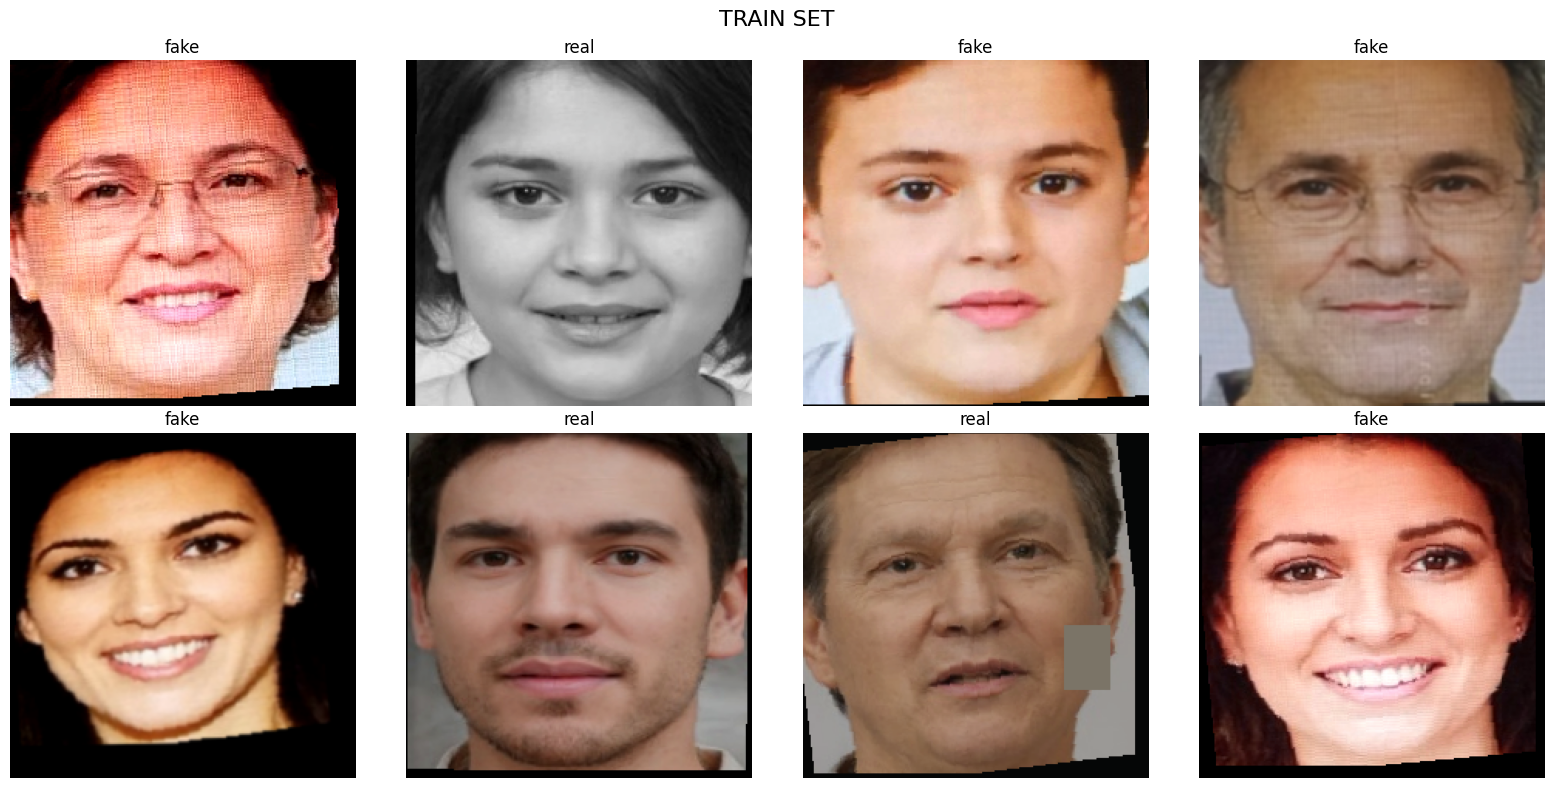

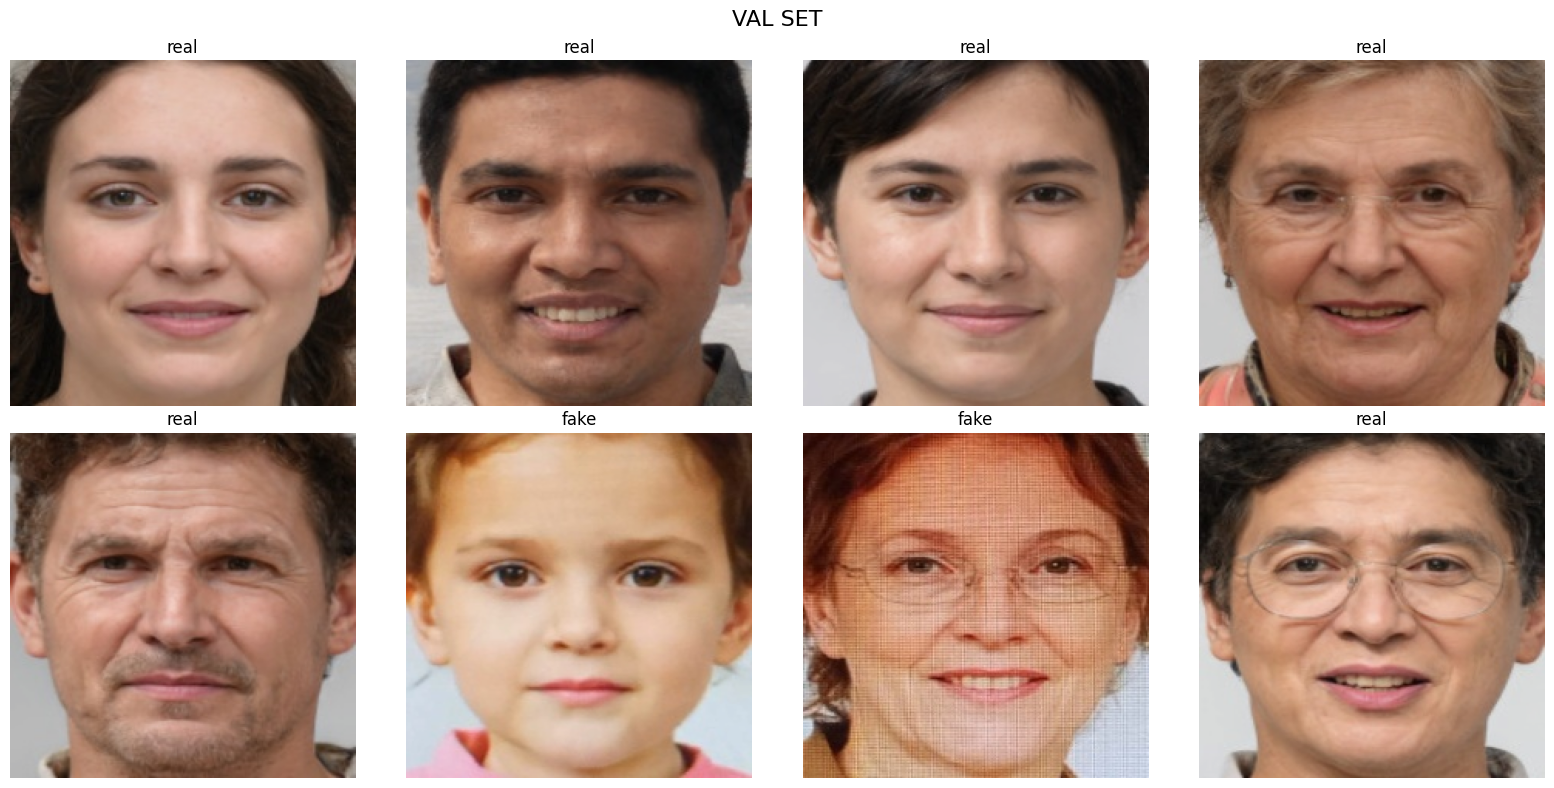

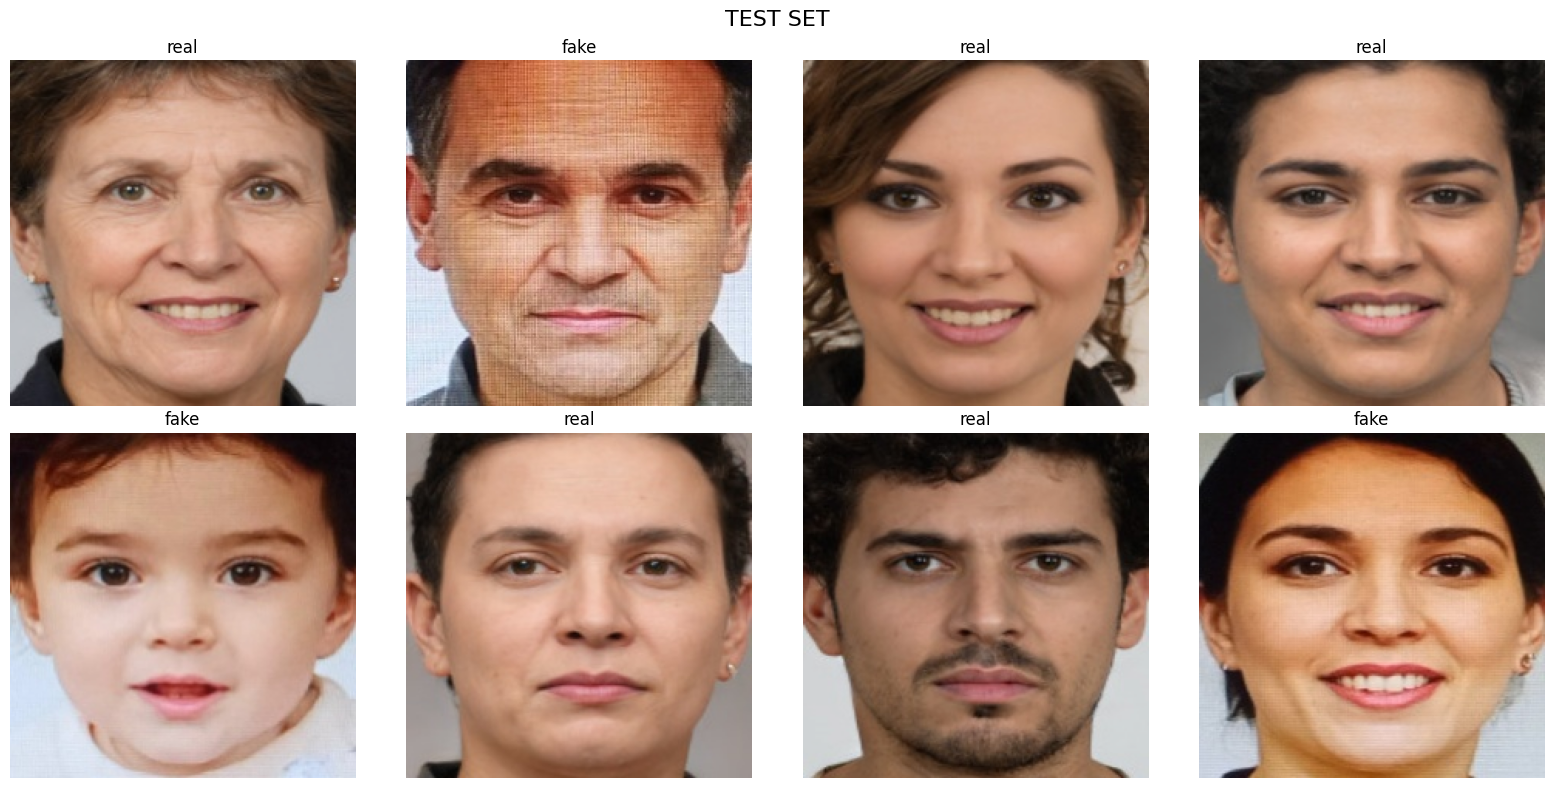

In [ ]:
# Add this to your notebook immediately
import matplotlib.pyplot as plt
import numpy as np

# Visualize random samples from train and val
def show_samples(dataset, title, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    fig.suptitle(title, fontsize=16)

    indices = np.random.choice(len(dataset), n, replace=False)

    for idx, i in enumerate(indices):
        img, label = dataset[i]
        ax = axes[idx // 4, idx % 4]

        # Denormalize image for display
        img_display = img.permute(1, 2, 0).numpy()
        img_display = img_display * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_display = np.clip(img_display, 0, 1)

        ax.imshow(img_display)
        ax.set_title(f"{class_names[label]}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()

# Show samples
show_samples(train_dataset, "TRAIN SET", n=8)
show_samples(val_dataset, "VAL SET", n=8)
show_samples(test_dataset, "TEST SET", n=8)

In [ ]:
# ========================================
# Training Loop
# ========================================

train_losses, train_accs = [], []
val_losses, val_accs = [], []
best_val_acc = 0.0
patience_counter = 0

print(f"\n{'='*50}")
print(f"STARTING TRAINING")
print(f"{'='*50}\n")

for epoch in range(NUM_EPOCHS):
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 50)

    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    scheduler.step()

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%")
    print(f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        patience_counter = 0

        # Save PyTorch model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, 'best_spoofnet_checkpoint.pth')

        # Save just the model weights
        torch.save(model.state_dict(), 'best_spoofnet_model.pth')

        print(f"✓ Best model saved! Validation Accuracy: {best_val_acc*100:.2f}%")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{PATIENCE}")

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"\n⚠ Early stopping triggered at epoch {epoch+1}")
        break

    print()


STARTING TRAINING

Epoch 1/5
--------------------------------------------------


Train Loss: 0.4460 | Train Acc: 90.65%
Val Loss:   0.3331 | Val Acc:   99.62%
Learning Rate: 0.000090
✓ Best model saved! Validation Accuracy: 99.62%

Epoch 2/5
--------------------------------------------------


Train Loss: 0.3886 | Train Acc: 95.85%
Val Loss:   0.3280 | Val Acc:   99.87%
Learning Rate: 0.000065
✓ Best model saved! Validation Accuracy: 99.87%

Epoch 3/5
--------------------------------------------------


Train Loss: 0.3722 | Train Acc: 97.15%
Val Loss:   0.3308 | Val Acc:   99.71%
Learning Rate: 0.000035
No improvement. Patience: 1/7

Epoch 4/5
--------------------------------------------------


Train Loss: 0.3636 | Train Acc: 97.93%
Val Loss:   0.3277 | Val Acc:   99.90%
Learning Rate: 0.000010
✓ Best model saved! Validation Accuracy: 99.90%

Epoch 5/5
--------------------------------------------------


Train Loss: 0.3598 | Train Acc: 98.24%
Val Loss:   0.3263 | Val Acc:   99.97%
Learning Rate: 0.000100
✓ Best model saved! Validation Accuracy: 99.97%



In [ ]:
print(f"\n{'='*50}")
print(f"TRAINING COMPLETED")
print(f"{'='*50}")
print(f"Best Validation Accuracy: {best_val_acc*100:.2f}%")
print(f"{'='*50}\n")


TRAINING COMPLETED
Best Validation Accuracy: 99.97%



In [ ]:
# ========================================
# Load Best Model for Testing
# ========================================

model.load_state_dict(torch.load('best_spoofnet_model.pth'))
model.eval()
print("Loaded best model for evaluation.\n")


Loaded best model for evaluation.



In [ ]:
# ========================================
# Test Model
# ========================================

def test_model(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Testing"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())

    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

print(f"{'='*50}")
print(f"TESTING ON TEST SET")
print(f"{'='*50}\n")

TESTING ON TEST SET



In [ ]:
test_preds, test_labels, test_probs = test_model(model, test_loader)
test_acc = (test_preds == test_labels).mean()

print(f"\nTest Accuracy: {test_acc*100:.2f}%\n")

Testing: 100%|██████████| 196/196 [00:06<00:00, 28.25it/s]


Test Accuracy: 99.94%



In [ ]:
# Confidence analysis
spoof_indices = test_labels == 0
real_indices = test_labels == 1

In [ ]:
if spoof_indices.any():
    spoof_confidences = test_probs[spoof_indices][:, 1]
    print(f"Average confidence for SPOOF predictions: {spoof_confidences.mean()*100:.2f}%")

if real_indices.any():
    real_confidences = test_probs[real_indices][:, 0]
    print(f"Average confidence for REAL predictions: {real_confidences.mean()*100:.2f}%")

Average confidence for SPOOF predictions: 10.10%
Average confidence for REAL predictions: 11.52%


In [ ]:
# Classification report
print(f"\n{'='*50}")
print(f"CLASSIFICATION REPORT")
print(f"{'='*50}\n")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))


CLASSIFICATION REPORT

              precision    recall  f1-score   support

        fake     1.0000    0.9987    0.9994      1546
        real     0.9987    1.0000    0.9994      1580

    accuracy                         0.9994      3126
   macro avg     0.9994    0.9994    0.9994      3126
weighted avg     0.9994    0.9994    0.9994      3126



In [ ]:
# Confusion matrix
print(f"{'='*50}")
print(f"CONFUSION MATRIX")
print(f"{'='*50}\n")
cm = confusion_matrix(test_labels, test_preds)
print(cm)
print(f"\nTrue Negatives (Real → Real):  {cm[0][0]}")
print(f"False Positives (Real → Spoof): {cm[0][1]}")
print(f"False Negatives (Spoof → Real): {cm[1][0]}")
print(f"True Positives (Spoof → Spoof): {cm[1][1]}")

CONFUSION MATRIX

[[1544    2]
 [   0 1580]]

True Negatives (Real → Real):  1544
False Positives (Real → Spoof): 2
False Negatives (Spoof → Real): 0
True Positives (Spoof → Spoof): 1580


In [ ]:
# Install ONNX and ONNX Runtime
!pip install onnx onnxruntime -q

print("✓ ONNX packages installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.4/17.4 MB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.0 MB/s eta 0:00:00
✓ ONNX packages installed successfully!


In [ ]:
# ========================================
# ONNX Export for Browser Deployment
# ========================================

print(f"\n{'='*50}")
print(f"EXPORTING MODEL TO ONNX FORMAT")
print(f"{'='*50}\n")

# Prepare model for export
model.eval()
model.to('cpu')  # Move to CPU for ONNX export

# Create dummy input
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE)

# Export to ONNX
onnx_path = 'spoofnet_model.onnx'


EXPORTING MODEL TO ONNX FORMAT



In [ ]:
try:
    torch.onnx.export(
        model,
        dummy_input,
        onnx_path,
        export_params=True,
        opset_version=11,
        do_constant_folding=True,
        input_names=['input'],
        output_names=['output'],
        dynamic_axes={
            'input': {0: 'batch_size'},
            'output': {0: 'batch_size'}
        },
        verbose=False
    )
    print(f"✓ Model successfully exported to: {onnx_path}")

    # Check file size
    onnx_size = os.path.getsize(onnx_path) / (1024 ** 2)
    print(f"✓ ONNX model size: {onnx_size:.2f} MB")

except Exception as e:
    print(f"✗ ONNX export failed: {str(e)}")

/tmp/ipython-input-1694635682.py:2: DeprecationWarning: You are using the legacy TorchScript-based ONNX export. Starting in PyTorch 2.9, the new torch.export-based ONNX exporter will be the default. To switch now, set dynamo=True in torch.onnx.export. This new exporter supports features like exporting LLMs with DynamicCache. We encourage you to try it and share feedback to help improve the experience. Learn more about the new export logic: https://pytorch.org/docs/stable/onnx_dynamo.html. For exporting control flow: https://pytorch.org/tutorials/beginner/onnx/export_control_flow_model_to_onnx_tutorial.html.
  torch.onnx.export(


✓ Model successfully exported to: spoofnet_model.onnx
✓ ONNX model size: 18.62 MB


In [ ]:
# ========================================
# Verify ONNX Model
# ========================================

print(f"\n{'='*50}")
print(f"VERIFYING ONNX MODEL")
print(f"{'='*50}\n")

try:
    import onnx

    # Load and check ONNX model
    onnx_model = onnx.load(onnx_path)
    onnx.checker.check_model(onnx_model)
    print("✓ ONNX model structure is valid")

    # Display model info
    print(f"✓ ONNX IR version: {onnx_model.ir_version}")
    print(f"✓ ONNX opset version: {onnx_model.opset_import[0].version}")

except ImportError:
    print("⚠ ONNX package not installed. Install with: pip install onnx")
except Exception as e:
    print(f"✗ ONNX verification failed: {str(e)}")



VERIFYING ONNX MODEL

✓ ONNX model structure is valid
✓ ONNX IR version: 6
✓ ONNX opset version: 11


In [ ]:
# ========================================
# Test ONNX Runtime Inference
# ========================================

print(f"\n{'='*50}")
print(f"TESTING ONNX RUNTIME INFERENCE")
print(f"{'='*50}\n")

try:
    import onnxruntime as ort

    # Create inference session
    ort_session = ort.InferenceSession(onnx_path)

    # Get input/output names
    input_name = ort_session.get_inputs()[0].name
    output_name = ort_session.get_outputs()[0].name

    print(f"✓ ONNX Runtime session created")
    print(f"  Input name: {input_name}")
    print(f"  Output name: {output_name}")

    # Test inference
    test_input = np.random.randn(1, 3, IMG_SIZE, IMG_SIZE).astype(np.float32)
    ort_output = ort_session.run([output_name], {input_name: test_input})

    print(f"✓ ONNX inference successful")
    print(f"  Output shape: {ort_output[0].shape}")
    print(f"  Output logits: {ort_output[0]}")

    # Compare PyTorch vs ONNX outputs
    model.eval()
    with torch.no_grad():
        pytorch_output = model(torch.from_numpy(test_input))
        pytorch_output = pytorch_output.numpy()

    # Calculate difference
    max_diff = np.abs(pytorch_output - ort_output[0]).max()
    print(f"\n✓ PyTorch vs ONNX max difference: {max_diff:.6f}")

    if max_diff < 1e-4:
        print("✓ Outputs match! ONNX model is ready for deployment.")
    else:
        print("⚠ Outputs differ slightly (normal for format conversion)")

except ImportError:
    print("⚠ ONNX Runtime not installed. Install with: pip install onnxruntime")
except Exception as e:
    print(f"✗ ONNX Runtime test failed: {str(e)}")



TESTING ONNX RUNTIME INFERENCE

✓ ONNX Runtime session created
  Input name: input
  Output name: output
✓ ONNX inference successful
  Output shape: (1, 2)
  Output logits: [[-0.26468524  0.32269597]]

✓ PyTorch vs ONNX max difference: 0.000000
✓ Outputs match! ONNX model is ready for deployment.
